In [1]:
# Final Project: CUNY Computational Methods Fall 2023
# Author: Andrew Dublin

# Note: The user must make sure that numpy version 1.20.3 (or later)
# is downloaded in order for the "lightkurve" package to function.

# If necessary, execute the following upgrades directly from the 
# Jupyter notebook. It might also be necessary to update "numexpr" 
# from Pandas.

# !pip install --upgrade numpy
# !pip install --upgrade numexpr
# !pip install --upgrade pandas
# !pip install scipy


Name of White Dwarf: TIC 257459955


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{ppm^{2}}{\\mu Hz}}$]'>

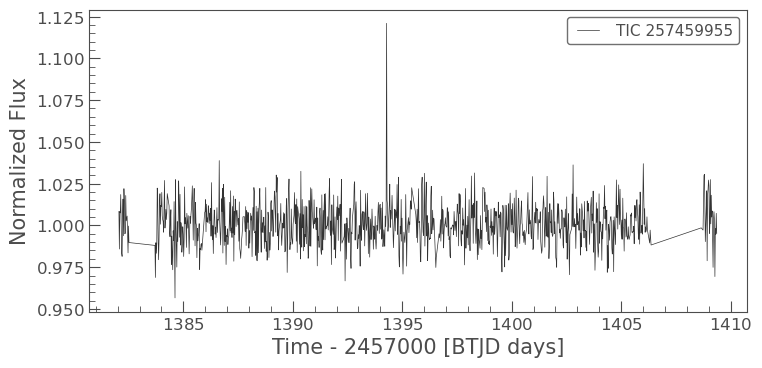

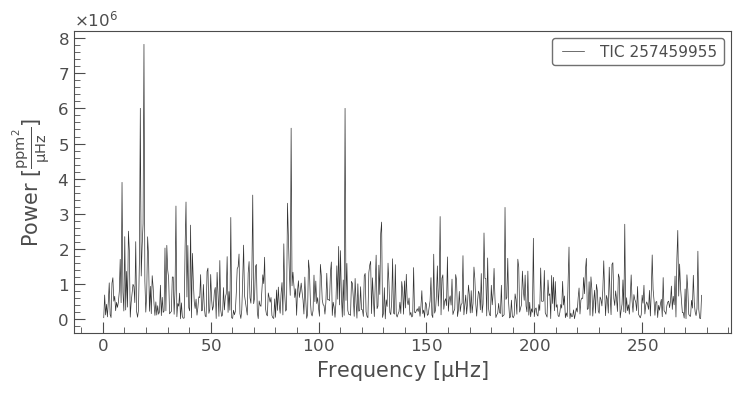

In [2]:
# This project will utilize the lightkurve package in Python

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import lightkurve as lk
import math
from tqdm import tqdm
from astropy import units as u

# Import the light curve of the desired white dwarf below. For this 
# project, we will analyze TIC 257459955.

# The user can search for any WD for which data exists in the 
# MAST database. Another possible WD with interesting light 
# curves is KIC 08626021. 

user_query = input("Name of White Dwarf: ")

search_result = lk.search_lightcurve(target=user_query)

# NB: When selecting the light curve data, be sure not to merge short
# and long-term cadence data; this will not give way to meaningful
# analysis. In addition, one should not "stitch" together an arbitrary
# number of light curves; examine one light curve at a time. 

lc = search_result[6].download() # Good for TIC 257459955
# lc = search_result[0].download() # Good for KIC 08626021
lc = lc[lc.quality == 0]
lc.plot()

# Note the different units (uHz) in the periodogram provided.
pg = lc.normalize(unit='ppm').to_periodogram(normalization='psd')
pg.plot()


In [3]:
# Part I: Use Fourier Analysis (FFT) to identify the peak frequencies
# in the light curve by transforming the light curve to a periodogram.
# Compare the reconstructed periodogram to the periodogram provided
# from the MAST data (displayed above). 

# Here we define the flux and time arrays. NaNs/infinite values (uncommon
# but possible for other light curves) are masked here to avoid complications
# and unreliable analysis.

flux_data = np.array(lc.flux)
masked_flux = ~np.isnan(flux_data) # boolean indicator
flux_array = flux_data[masked_flux]

time_data = np.array(lc.time.value)
time_array = time_data[masked_flux]

# For plotting purposes, we will only consider positive frequencies
# and their associated power specta. 

# Sampling considerations:

sampling_freq = 1/np.median(np.diff(time_array))
coeffs_fft = np.fft.rfft(flux_array)
freqs = np.fft.fftfreq(n=len(flux_array), d=1/sampling_freq)

positive_freqs = np.where(freqs>=0)
power_density = np.abs(coeffs_fft[positive_freqs])**2
power_normalized = power_density/np.max(power_density)


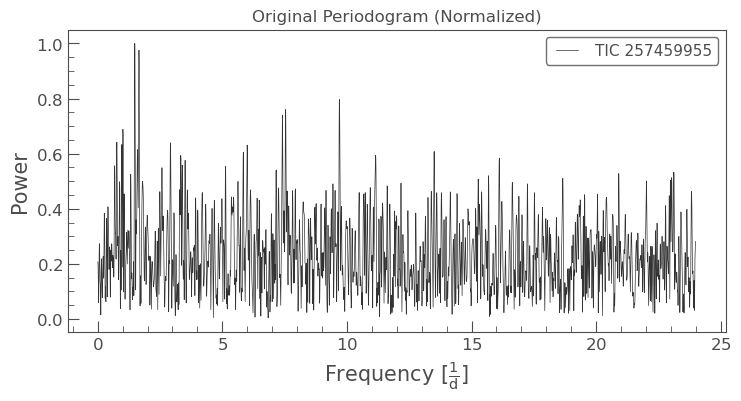

Text(0.5, 0, 'Frequency (1/d)')

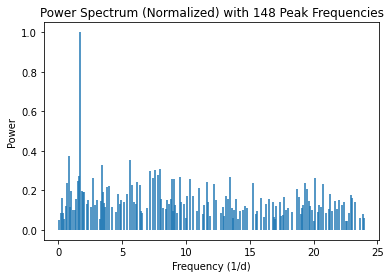

In [4]:
# Now let us identify the peak frequencies using the scipy.signal
# "find_peaks" function. This function returns the indices of the 
# power spectrum array associated with the peak frequencies. This 
# function returns a 2D array (only consider the first component). 
# The import statement is included for clarity. The original 
# periodogram is also included for clarity (note the change in units).

from scipy.signal import find_peaks

pgm = lc.to_periodogram()
pgm = pgm/pgm.power.max()
pgm.plot()
plt.title('Original Periodogram (Normalized)')
plt.show()

# Create the "peak periodogram" using the results of the FFT.
# Note that depending on the prominence threshold chosen (below), 
# this step of the process can introduce significant error. 

threshold = 0.7e-7 # Good for TIC 257459955
# threshold = 2.2e-7 # Good for KIC 08626021
power_peak_indices = find_peaks(power_normalized[positive_freqs], prominence=threshold)
peak_freqs = freqs[power_peak_indices[0]] 

fig, ax = plt.subplots()
peak_freq_power = power_normalized[positive_freqs][power_peak_indices[0].astype(int)]
ax.vlines(peak_freqs, 0, peak_freq_power/np.max(peak_freq_power))
plt.title(f'Power Spectrum (Normalized) with {len(peak_freqs)} Peak Frequencies')
plt.ylabel('Power')
plt.xlabel('Frequency (1/d)')


In [5]:
# Part II: Now let us apply the non-linear least squares optimization 
# method to each of the sine/cosine waves corresponding to the peak
# frequencies. Finally, we will sum all of these components and 
# perform a statistical analysis of the final (fitted) model.

# We will approximate the original light curve as a linear combination 
# of either sine or cosine waves. Assume that the most significant 
# contributions to the overall sum arise from the peak frequencies. 
# This should be a reasonable model (at the very least a reasonable 
# approximation) to the original light curve. For a given wave constituent
# at a given peak frequency, there exist two parameters (amplitude and 
# phase) that are to be optimized.

# First define the relevant functions (to be used later):

def model_cos(t, A, f, phi):
    
    # Ignore the vertical shift parameter.
    
    return A*np.cos(2*np.pi*f*t+phi)

def compute_chi_sq(n, sample, population):
    
    chi_squared = (n-1)*np.var(sample)/np.var(population)
    
    return chi_squared

def compute_rmse(L, observed, expected):
    
    s = np.sum((observed-expected)**2)
    
    rmse = np.sqrt((1/L)*s)
    
    return rmse


In [6]:
# NLLS Optimization: Initialize guesses for the optimization 
# parameters.

fitted_models = []
optimal_param_covariances = []

guess_amp = 0.5*np.ptp(flux_array)

num_fits = len(peak_freqs)

for particular_freq in tqdm(peak_freqs[:num_fits]):
    
    # Convert from astropy quantity to np array
    part_peak_freq = particular_freq.item() 

    # No a priori reason to assume a phase offset
    guess_phi = 0
    
    # Store the initial values and guesses. 
    p0 = np.array([float(guess_amp), float(part_peak_freq), float(guess_phi)])
    
    # Store all times and fluxes as arrays (avoiding astropy structures)
    time_array_data = np.array([float(time) for time in time_array])
    flux_array_data = np.array([float(flux) for flux in flux_array])
    
    # Only perform the fit during the periods of reported flux
    fit_indices = np.where(flux_array_data!=0)
    
    # Perform the NLLS optimization process
    opt_params, covariances = sp.optimize.curve_fit(model_cos, xdata=time_array_data[fit_indices], ydata=flux_array_data[fit_indices]-1, p0=p0)

    # Compute the optimal fits
    individual_opt_fit = model_cos(time_array_data, *opt_params)
    fitted_models.append(individual_opt_fit)

    # Store the covariance matrix for each peak frequency
    optimal_param_covariances.append(covariances)

# Sum over the time domain axis to reconstruct the light curve
reconstructed_light_curve = np.sum(fitted_models, axis=0) + 1

# Collect the covariance matrices for each of the peak frequencies
optimal_param_covariances = np.array(optimal_param_covariances)


100%|██████████| 148/148 [00:00<00:00, 431.56it/s]


In [7]:
# Statistical Analysis:

final_chi_sq = compute_chi_sq(n=3, sample = reconstructed_light_curve, population = flux_array_data)
print(f"Chi-Squared Value of Reconstructed Light Curve: {final_chi_sq:.2f}")

final_rmse = compute_rmse(L=len(reconstructed_light_curve), observed = reconstructed_light_curve, expected = flux_array_data)
print(f"Root Mean-Squared Error: {final_rmse:.2f}")


Chi-Squared Value of Reconstructed Light Curve: 1.33
Root Mean-Squared Error: 0.01


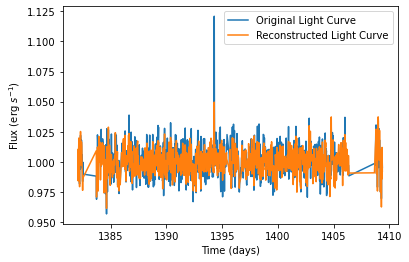

In [8]:
# Superimpose the reconstructed light curve over the original light 
# curve for visual inspection. Depending on the light curve data, the 
# vertical adjustment can be changed manually. 

non_zero_flux_data = flux_array_data != 0
vert_adj = 0 # Good for TIC 257459955
# vert_adj = 400 # Good for KIC 08626021

fig, ax = plt.subplots()
ax.plot(time_array_data[non_zero_flux_data], flux_array_data[non_zero_flux_data], label=f'Original Light Curve')
ax.plot(time_array_data[non_zero_flux_data], reconstructed_light_curve[non_zero_flux_data]+vert_adj, label=f'Reconstructed Light Curve')
ax.legend()
ax.set_ylabel('Flux (erg $s^{-1}$)')
ax.set_xlabel('Time (days)')
plt.show()
